In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Initialization

In [2]:
# manually define building names
buildingnames = ['304Elm',
                 'YUAG',
                 'Berkeley',
                 'Hopper',
                 'Davenport',
                 'Malone',
                 'Sprague',
                 'Trumbull',
                 '17HH']

In [3]:
# read steam data from csv into a new dataframe
raw = pd.read_csv('data/steam_raw.csv',index_col=0,na_values=['Bad','#VALUE!'])

# save units information, to be converted once I know the factors
unit_info = raw.head(1)
raw.drop('units:',inplace=True)

# housekeeping
raw = raw.astype(float)
raw = raw.iloc[0:5063]

In [4]:
# reindex appropriately by hourly datetime
raw.index = pd.to_datetime(raw.index,format='%d-%b-%y %H:00:00')

# add missing rows by full reindexing
correct_dt = pd.DatetimeIndex(start='2018-01-01 01:00:00',end='2018-07-31 00:00:00',freq='h')
raw = raw.reindex(index=correct_dt)

# rename columns
raw.columns = buildingnames

# remove YUAG for now, too much missing data
raw.drop('YUAG',axis=1,inplace=True)

In [5]:
# remove impossible outliers with std dev
raw = raw.where(raw > raw.median() - 5*raw.std())
raw = raw.where(raw < raw.median() + 5*raw.std())

In [6]:
# interpolate gaps in consumption data 6 hours and shorter, optional
for k in raw.columns:
    raw[k] = fn.limited_impute(raw[k],6)

## Error Identification & Removal

Missing values:
304Elm        0
Berkeley     19
Hopper        0
Davenport     0
Malone        0
Sprague       0
Trumbull      0
17HH          0
dtype: int64


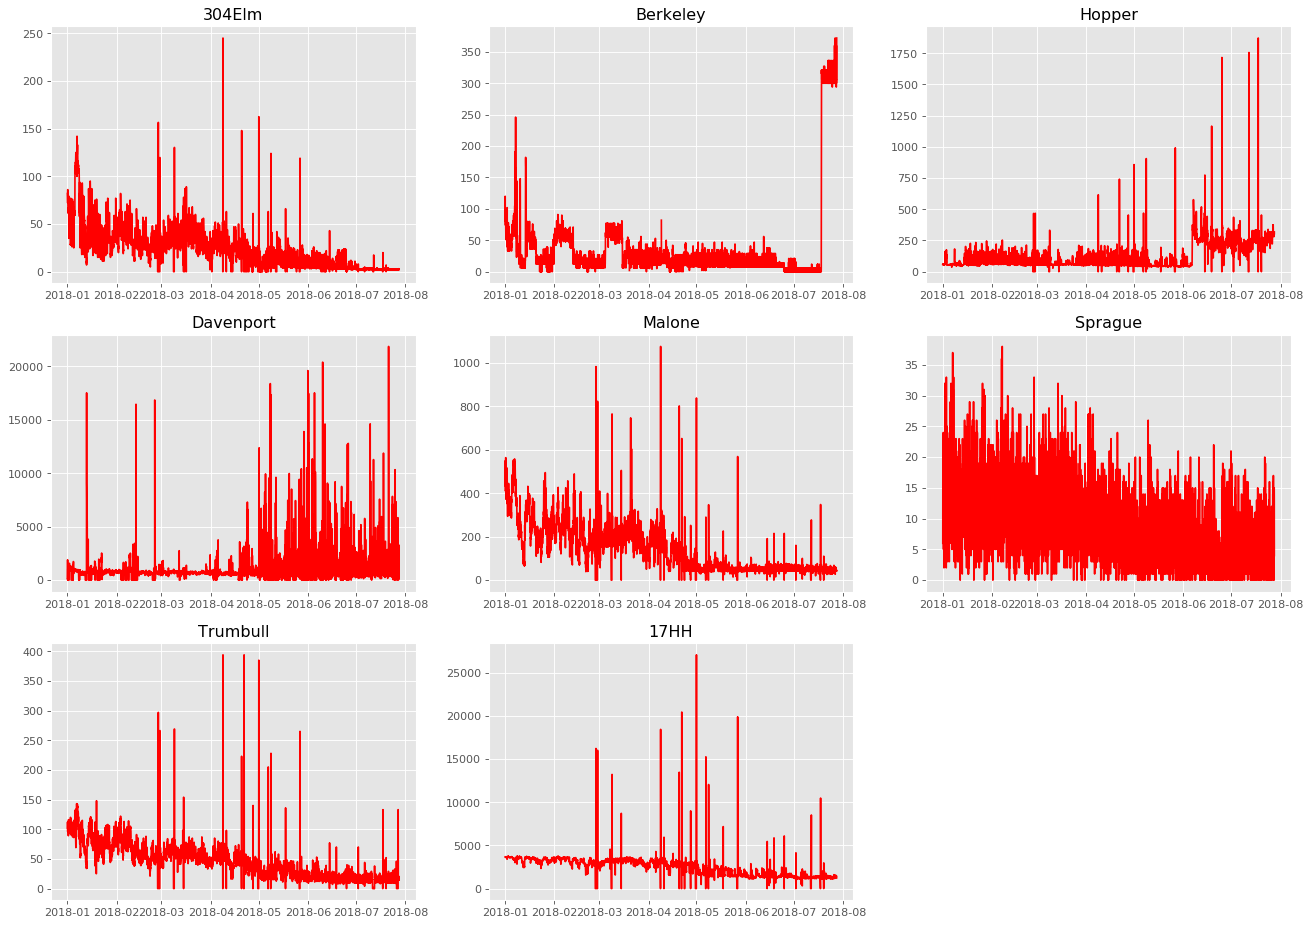

In [7]:
demand = raw.diff()
demand['Berkeley'] = raw['Berkeley'] # Berkeley had already been converted to demand values
demand = demand.drop(raw.index[0]).where(demand>=0)

# diagnostics
print('Missing values:')
print(demand.isnull().sum())
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 02:00:00','2018-07-27 23:00:00')

New missing values from this step:
304Elm       146
Berkeley      51
Hopper       136
Davenport    127
Malone       129
Sprague       28
Trumbull     179
17HH         130
dtype: int64


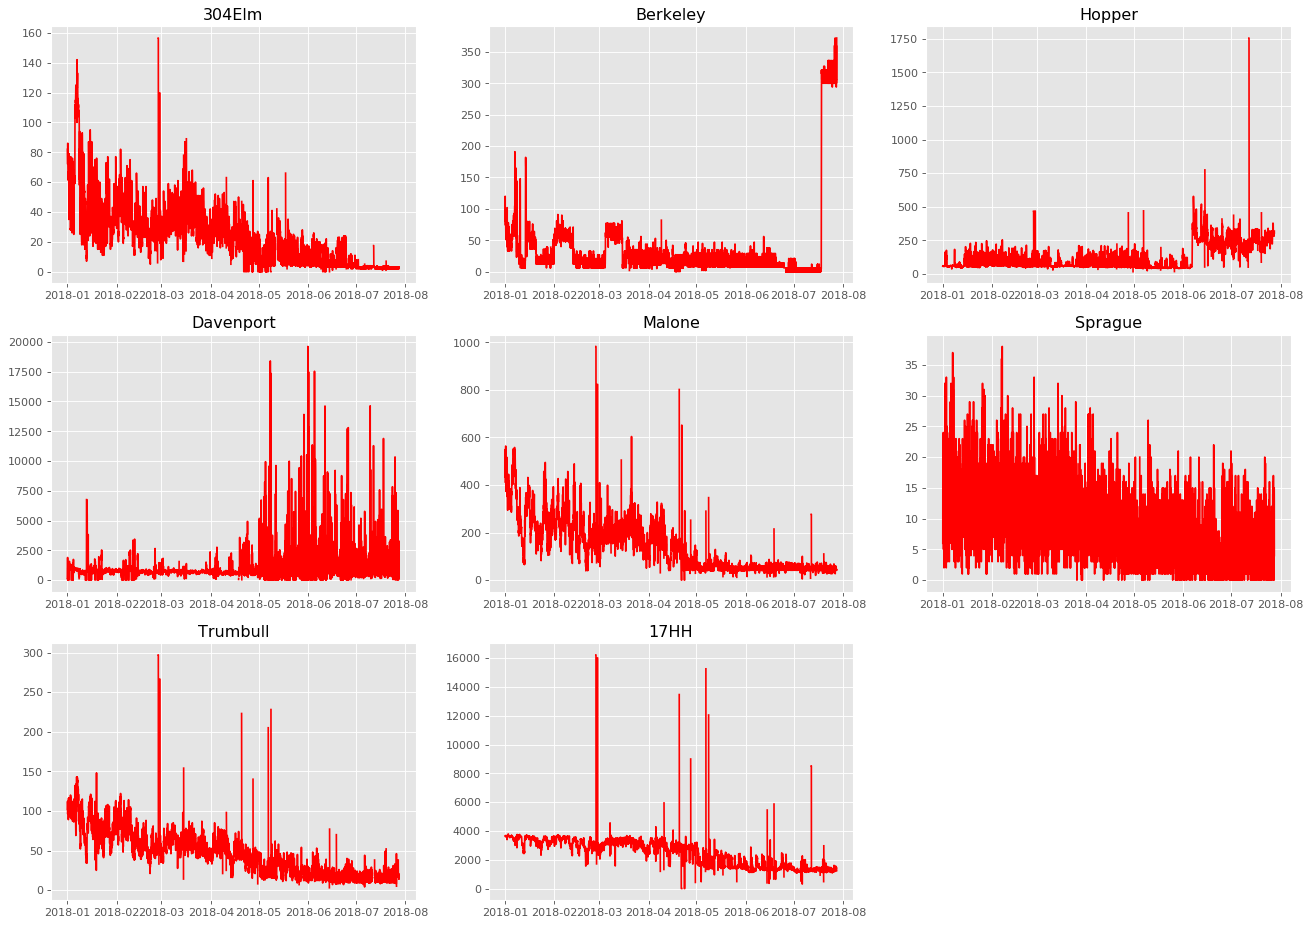

In [8]:
# define max and min cutoffs using median daily max/min over a seven-day period
max_cutoff = (demand.resample('2D').max().rolling(4,center=True).median()
                    .reindex_like(demand).interpolate(method='linear').fillna(method='bfill')*2
             )

min_cutoff = (demand.resample('2D').min().rolling(4,center=True).median()
                    .reindex_like(demand).interpolate(method='linear').fillna(method='bfill')*0.3
             )

# remove values violating these cutoffs
demand.where(demand < max_cutoff, inplace=True)
demand.where(demand >= min_cutoff, inplace=True)

# diagnostics
new_errors = demand.isnull().sum() - errors
print('New missing values from this step:')
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 02:00:00','2018-07-27 23:00:00')

## Imputation of missing values

Number of missing values remaining:
304Elm        94
Berkeley       0
Hopper       102
Davenport     57
Malone        92
Sprague        0
Trumbull     146
17HH          93
dtype: int64


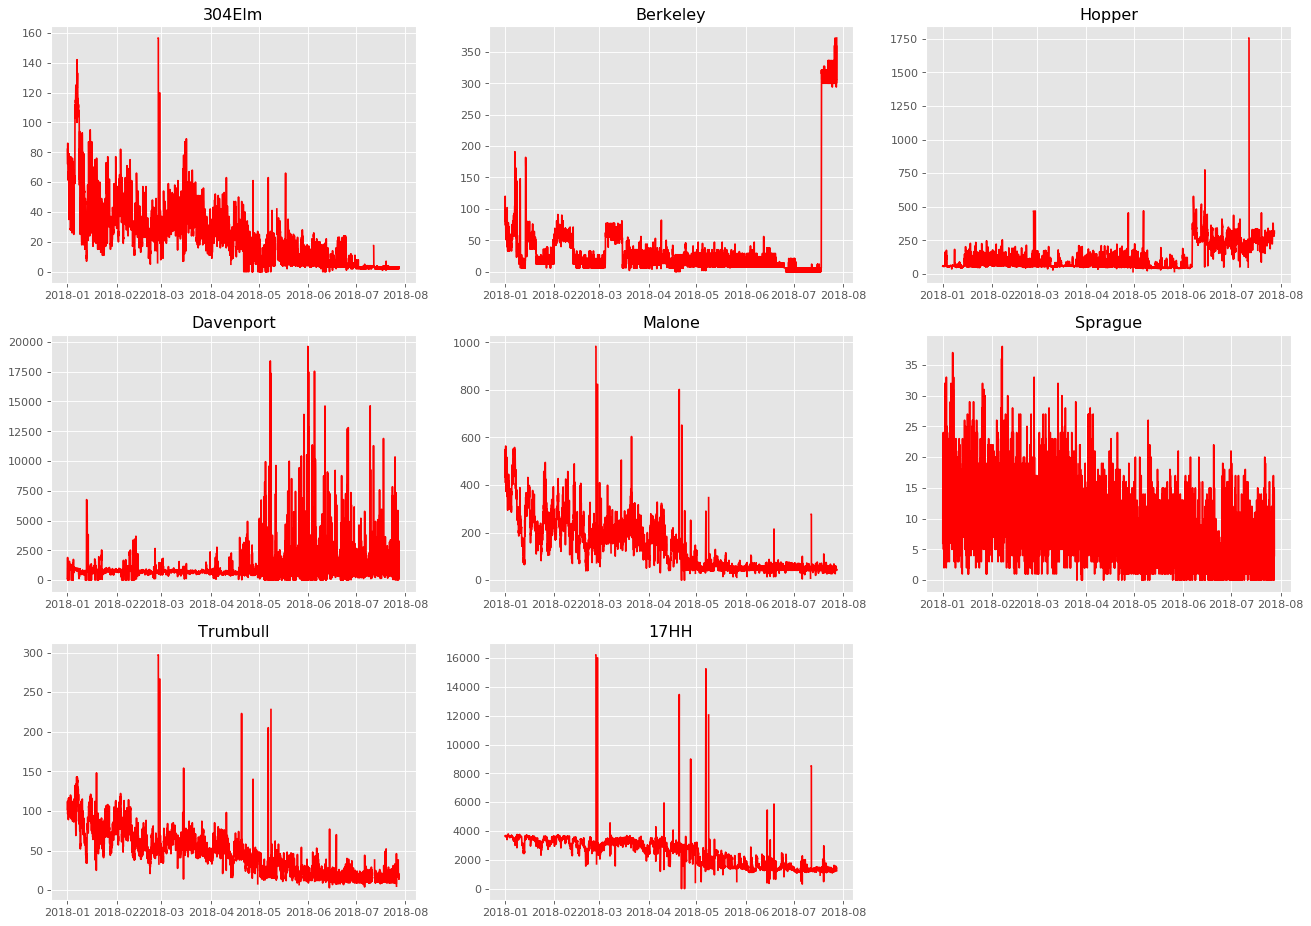

In [9]:
dense = demand.copy(deep=True)

# interpolate gaps shorter than 6 hours
for k in dense.columns:
    dense[k] = fn.limited_impute(dense[k],6)

print('Number of missing values remaining:')
print(dense.isnull().sum())

fn.plot_all(dense,'2018-01-01 02:00:00','2018-07-27 23:00:00')

In [10]:
# interpolate gaps longer than 6 hours using least-squares optimized sinusoidal fit
for k in dense.columns:
    dense[k] = fn.sine_impute(dense[k])

# print('Number of missing values remaining:')
# print(dense.isnull().sum())

fn.plot_all(dense,'2018-03-05 01:00:00','2018-03-10 23:00:00')

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

### unused code

In [ ]:
## chunk-based error removal method, worked well for electricity but not as well here

# chunk_size = 360
# i=0

# while i < len(demand):
#     end = i+chunk_size
#     if end > len(demand): end = len(demand)
#     demand[i:end].where(demand[i:end] > demand[i:end].rolling(18).min().median()*0.3, inplace=True)
#     demand[i:end].where(demand[i:end] < demand[i:end].rolling(18).max().median()*2, inplace=True)
#     i = i+chunk_size
